# Clustering

In [ ]:
  # Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clasificación vs Clustering

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

In [ ]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show();

## K-means 

**Documentación**: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans


**NOTA**: En problemas reales, es fundamental **estandarizar o escalar los datos** antes de aplicar el algoritmo k-means

In [ ]:
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [ ]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

Entrena un k-means con los datos anteriores

Podemos pintar las regiones de decisión (diagrama de Voronoi)

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='r'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=30, linewidths=30,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

El método `transform` Mide la distancia a cada uno de los centroides

**Do it yourself**: Calcula la distancia euclídea de cada punto de `X_new` a cada centroide

### Inertia 

Uno de los parámetros de kmeans era el número de ejecuciones del algoritmo (`n_init`). Para seleccionar el mejor modelo, necesitamos evaluar el desempeño de cada uno. Al no tener variable objetivo, lo único que podemos medir es la suma de las distancias entre cada punto y su centroide (métrica de inercia). El algoritmo con menor inercia será el elegido


**Do it yourself**: Usando `kmeans.transform(X)` y `kmeans.labels_` comprueba que la inercia es la suma de las distancias al cuadrado de cada punto a su centroide

El método `score()` devuelve el negativo de la inercia. ¿Por qué negativo? Porque se respeta la regla "_cuanto mayor, mejor_" de sklearn 


### Buscando el número óptimo de clusters

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Para elegir el número óptimo de clusters, **no** podemos simplemente elegir el valor de *k* que minimice la inercia, porque ésta va disminuyendo a medida que incrementamos *k*. Podemos hacer un plot de la inercia en función de *k* y analizar la curva

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Codo',
             xy=(4, inertias[3]),
             xytext=(0.4, 0.65),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='red', shrink=0.1)
            )

save_fig("inertia_vs_k_plot")
plt.show()

In [ ]:
plot_clusterer_comparison(kmeans_k4, kmeans_k5, X, "$k=4$", "$k=5$")
save_fig("k4_k5_comparison")
plt.show()

Otra forma de elegir el número de clusters es mediante el *silhouette score*, que consiste en la media de los coeficientes *silhouette* sobre todos los puntos. Este coeficiente se calcula como $(b-a)/\max(a,b)$, siendo $a$ la distancia media de los puntos en el mismo cluster (distancia intra-cluster), y $b$ la distancia media al cluster más cercano 

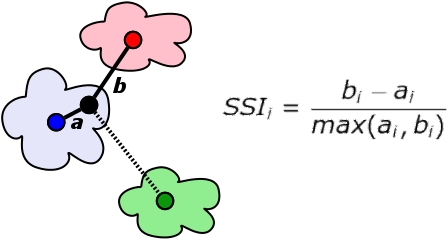

Este coeficiente varía entre -1 y 1. Cuanto más próximo sea a +1 quiere decir que el punto está bien situado dentro de su cluster y está alejado de otros clusters. 

Un coeficiente igual a 0 indica que está cercano a una frontera entre clusters, y un coeficiente igual a -1 indica que el punto puede haber sido asignado a un cluster erróneo

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Esta visualización aporta más información que la anterior. Se confirma que $k=4$ es muy buena opción, también indica que $k=5$ es también buena.  

Existen también los diagramas de siluetas, donde el eje *y* representa cada cluster y el eje *x* es el coeficiente de silhouette. La anchura de cada "cuchillo" indica el número de puntos en cada cluster, y el contorno del "cuchillo" son los puntos con diferentes coeficientes. Hay que buscar cuchillos poco afilados, homogéneos y que superen la media del coeficiente


In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

### Limitaciones de Kmeans

Cuando tenemos los puntos muy concentrados y con formas no concéntricas, el algoritmo de k-means puede no funcionar bien

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [ ]:
plot_clusters(X)

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

## DBSCAN

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


#### DBSCAN Predictions

In [ ]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

## Clustering  jerárquico

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
X, y = make_blobs(
        n_samples    = 200, 
        n_features   = 2, 
        centers      = 4, 
        cluster_std  = 0.60, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
ax.set_title('Datos simulados')
ax.legend();

Con la clase `sklearn.cluster.AgglomerativeClustering` de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo hierarchical clustering aglomerativo. Entre sus parámetros destacan:

- `n_clusters`: determina el número de clusters que se van a generar. En su lugar, su valor puede ser `None` si se quiere utilizar el criterio de distancia para crear los clusters o crecer todo el dendograma.

- `distance_threshold`: distancia (altura del dendograma) a partir de la cual se dejan de unir los clusters. Indicar `distance_threshold=0` para crecer todo el árbol.

Además, el parámetro `linkage` permite escoger cómo queremos calcular la ditancia entre clusters (single, complete o average)
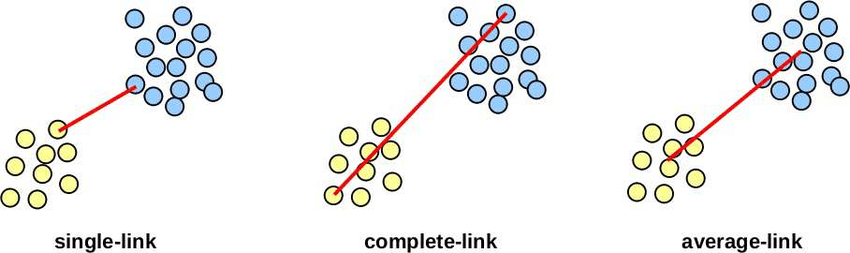

Una forma de identificar el número de clusters, es inspeccionar visualmente el dendograma y decidir a qué altura se corta para generar los clusters. Por ejemplo, para los resultados generados, parece sensato cortar el dendograma a una altura de entre 5 y 10, de forma que se creen 4 clusters.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
altura_corte = 6
plot_dendrogram(hclust, color_threshold=altura_corte, ax=ax)
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

También podemos usar el coeficiente de *silhouette*

In [ ]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Una vez identificado el número óptimo de clusters, se reentrena el modelo indicando este valor.

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
for i in np.unique(y):
    ax[0].scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
ax[0].set_title('Datos simulados')
ax[0].legend();
ax[1].scatter(X[:,0],X[:,1],c=modelo_hclust.fit_predict(X_scaled),edgecolor = 'black', ) 
ax[1].set_title('Datos clustering jerárquico')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
for i in np.unique(y):
    ax[0].scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
ax[0].set_title('Datos simulados')
ax[0].legend();
ax[1].scatter(X[:,0],X[:,1],c=modelo_hclust2.fit_predict(X_scaled),edgecolor = 'black', ) 
ax[1].set_title('Datos clustering jerárquico distancia = 2')